In [8]:
import numpy as np 
import pysindy as ps 
import pandas as pd 
import random
import matplotlib.pyplot as plt
import pickle

from sklearn.metrics import mean_squared_error
from scipy.integrate import solve_ivp
from numpy import genfromtxt

from matplotlib import style
style.use('seaborn-white')

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning) 

In [9]:
df = pd.read_csv('../../../Data/JIANG/dataVehicle101.csv', header=None,low_memory=False, encoding='UTF-8')
df = df.rename(columns={0:"TIME",1:"LEAD_POS",2:"FOLLOW_POS",3:"LEAD_VEL",4:"FOLLOW_VEL",5:"LEAD_LENGTH"})
df = pd.DataFrame(df)
print(df)

       TIME    LEAD_POS  FOLLOW_POS  LEAD_VEL  FOLLOW_VEL  LEAD_LENGTH
0     31993   200.67055   188.04780   4.44200     0.00000            5
1     31994   201.11260   188.04780   4.39912     0.00000            5
2     31995   201.55044   188.04780   4.35767     0.00000            5
3     31996   201.98436   188.04780   4.32056     0.00000            5
4     31997   202.41491   188.04780   4.29046     0.00000            5
...     ...         ...         ...       ...         ...          ...
2880  34873  2808.34544  2796.11119   6.35455     5.83341            5
2881  34874  2808.98007  2796.69322   6.33798     5.80710            5
2882  34875  2809.61276  2797.27252   6.31573     5.77881            5
2883  34876  2810.24298  2797.84889   6.28871     5.74871            5
2884  34877  2810.87036  2798.42219   6.25883     5.71735            5

[2885 rows x 6 columns]


In [10]:
############ Converting Python DataFrames to Numpy Arrays ############

t = np.asarray(df["TIME"])
leadPos = np.asarray(df['LEAD_POS']) # Leading vehicle position 
followPos = np.asarray(df['FOLLOW_POS']) # Follow vehicle position 
vlead = np.asarray(df['LEAD_VEL']) # Leading vehicle velocity
v = np.asarray(df['FOLLOW_VEL']) # Follow vehicle velocity
leadLen = np.asarray(df["LEAD_LENGTH"]) # lead vehicle length 
leadVehLen = df.iat[0,5]
s = leadPos - followPos - leadLen[0]
#dt = t[1] - t[0]
dt = 0.1

sCheck = s<=0   # making sure that it is positive 
vehLen = leadLen!=5.196000000000001  # check if all the vehicles have the same length 
print(np.count_nonzero(vehLen)) # count the number of True 
print(np.count_nonzero(sCheck)) # count number of True 

statTrajec = 0
endTrajec = -1

t = np.linspace(0, 288.4, 2884, endpoint=False) # 288.4 for JIANG # 188.9 for NAPOLI
#t = t[statTrajec:endTrajec]

# Without Scaling 
v = v[statTrajec:endTrajec]
s = s[statTrajec:endTrajec]
vlead = vlead[statTrajec:endTrajec]

followPos = followPos[statTrajec:endTrajec]
leadPos = leadPos[statTrajec:endTrajec]

############ Calculating the Follower Derivative ############

FD = ps.SmoothedFiniteDifference()
v_p = FD(v, t) #HDWY Derivative #(670,1)
v_p = np.reshape(v_p, (v.size,)) #(670,)
  
min_acc = np.min(v_p)  # min acceleration 
max_acc = np.max(v_p)  # max acceleration 

2885
0


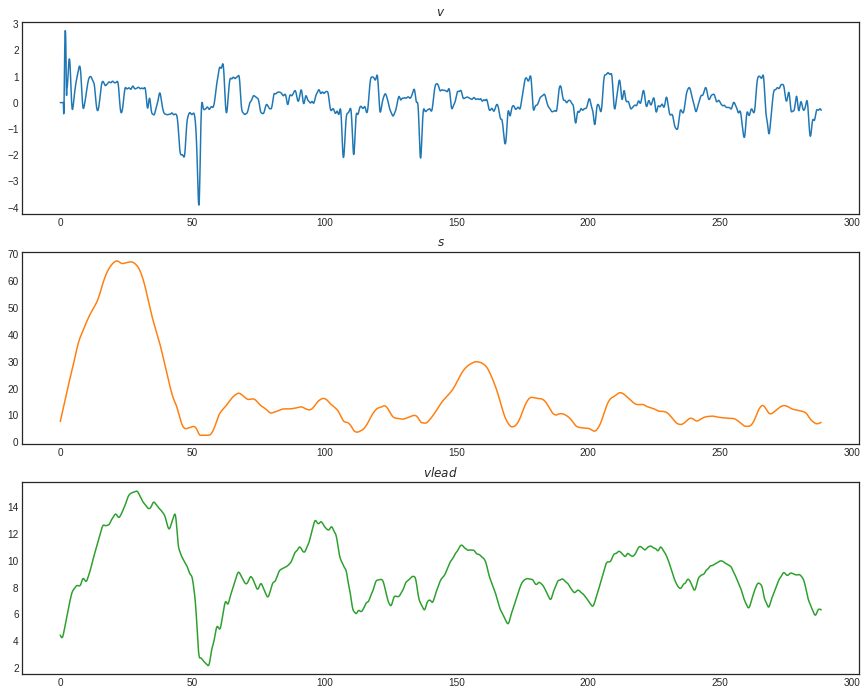

In [11]:
# Plotting the data
# plt.rc('font', size=10)
fig, (ax1,ax2,ax3) = plt.subplots(3)

statTraj = 0 #7000
endsTraj = -1 #8900

fig.set_figheight(12)
fig.set_figwidth(15)
#ax1.plot(t[vehCon][statTraj:endsTraj], v[vehCon][statTraj:endsTraj])
ax1.plot(t[statTraj:endsTraj], v_p[statTraj:endsTraj])
ax1.set_title('$v$')
ax2.plot(t[statTraj:endsTraj], s[statTraj:endsTraj], 'tab:orange')
ax2.set_title('$s$')
ax3.plot(t[statTraj:endsTraj], vlead[statTraj:endsTraj], 'tab:green')
ax3.set_title('$vlead$')

plt.show()

# LSTM

In [12]:
st_Traj = 0
en_Traj = 2307 #1511 #9405 # 2307

X_train = np.stack((v[st_Traj:en_Traj],s[st_Traj:en_Traj],vlead[st_Traj:en_Traj],t[st_Traj:en_Traj]), axis=1)

Y_train = np.stack((v_p[st_Traj:en_Traj],t[st_Traj:en_Traj]), axis=1)
#Y_train = np.stack((v[st_Traj:en_Traj],t[st_Traj:en_Traj]), axis=1)
#Y_train = np.stack((s[st_Traj:en_Traj],t[st_Traj:en_Traj]), axis=1)

X_prior = np.stack((v,s,vlead,t), axis=1)  # For plotting in this section 

X_Full = np.stack((v,s,vlead,v_p), axis=1)
#X_Full = np.stack((v,s,vlead,v), axis=1)
#X_Full = np.stack((v,s,vlead,s), axis=1)

np.savetxt("lstm_data.csv", X_Full, delimiter=",")

In [18]:
df_lstm = pd.read_csv("lstm_data.csv", header=None,low_memory=False, encoding='UTF-8')
df_lstm = df_lstm.rename(columns={0:"FOLLOW_VEL",1:"HEADWAY",2:"LEAD_VEL",3:"FOLLOW_ACC"})
df_lstm = pd.DataFrame(df_lstm)
df_lstm

,FOLLOW_VEL,HEADWAY,LEAD_VEL,FOLLOW_ACC
0,0.00000,7.62275,4.44200,0.000000
1,0.00000,8.06480,4.39912,0.000000
2,0.00000,8.50264,4.35767,0.000000
3,0.00000,8.93656,4.32056,0.000000
4,0.00000,9.36711,4.29046,0.000000
...,...,...,...,...
2879,5.85798,7.18282,6.36563,-0.240952
2880,5.83341,7.23425,6.35455,-0.252503
2881,5.80710,7.28685,6.33798,-0.270029
2882,5.77881,7.34024,6.31573,-0.293531


In [19]:
target = 'FOLLOW_ACC'
features = list(df_lstm.columns.difference([target]))

past_seq = 1
df_lstm[target] = df_lstm[target].shift(-past_seq)
df_lstm = df_lstm.iloc[:-past_seq]
df_lstm

,FOLLOW_VEL,HEADWAY,LEAD_VEL,FOLLOW_ACC
0,0.00000,7.62275,4.44200,0.000000
1,0.00000,8.06480,4.39912,0.000000
2,0.00000,8.50264,4.35767,0.000000
3,0.00000,8.93656,4.32056,0.000000
4,0.00000,9.36711,4.29046,0.000000
...,...,...,...,...
2878,5.88142,7.13289,6.37222,-0.240952
2879,5.85798,7.18282,6.36563,-0.252503
2880,5.83341,7.23425,6.35455,-0.270029
2881,5.80710,7.28685,6.33798,-0.293531


In [20]:
test_start = en_Traj
df_lstm_train = df_lstm.loc[:test_start].copy()
df_lstm_test = df_lstm.loc[test_start:].copy()

In [21]:
target_mean = df_lstm_train[target].mean()
target_stdev = df_lstm_train[target].std()

vel_mean = df_lstm_train['FOLLOW_VEL'].mean()
vel_stdev = df_lstm_train['FOLLOW_VEL'].std()

headway_mean = df_lstm_train['HEADWAY'].mean()
headway_stdev = df_lstm_train['HEADWAY'].std()

for c in df_lstm_train.columns:
    mean = df_lstm_train[c].mean()
    stdev = df_lstm_train[c].std()

    df_lstm_train[c] = (df_lstm_train[c] - mean) / stdev
    df_lstm_test[c] = (df_lstm_test[c] - mean) / stdev

In [22]:
df_lstm_train.head(11)

,FOLLOW_VEL,HEADWAY,LEAD_VEL,FOLLOW_ACC
0,-2.662783,-0.691616,-1.848280,-0.07445
1,-2.662783,-0.664741,-1.864813,-0.07445
2,-2.662783,-0.638123,-1.880796,-0.07445
3,-2.662783,-0.611742,-1.895105,-0.07445
4,-2.662783,-0.585567,-1.906710,-0.07445
5,-2.662783,-0.559546,-1.914696,-0.07445
6,-2.662783,-0.533616,-1.918224,-0.07445
7,-2.662783,-0.507700,-1.916562,-0.07445
8,-2.662783,-0.481713,-1.909105,-0.07445
9,-2.662783,-0.455559,-1.895475,-0.07445


In [23]:
class SequenceDataset(Dataset):
    def __init__(self, dataframe, target, features, sequence_length=5):
        self.features = features
        self.target = target
        self.sequence_length = sequence_length
        self.y = torch.tensor(dataframe[self.target].values).float()
        self.X = torch.tensor(dataframe[self.features].values).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i): 
        if i >= self.sequence_length - 1:
            i_start = i - self.sequence_length + 1
            x = self.X[i_start:(i + 1), :]
        else:
            padding = self.X[0].repeat(self.sequence_length - i - 1, 1)
            x = self.X[0:(i + 1), :]
            x = torch.cat((padding, x), 0)

        return x, self.y[i]

In [24]:
#i = 0
#sequence_length = 10

#train_dataset = SequenceDataset(
#    df_lstm_train,
#    target=target,
#    features=features,
#    sequence_length=sequence_length
#)

#X, y = train_dataset[i]
#print(X)
#print(y)

In [25]:
#train_loader = DataLoader(train_dataset, batch_size=3, shuffle=False)

#X, y = next(iter(train_loader))
#print(X.shape)
#print(X)

In [26]:
val_Traj = 2048 #8465 #1359
df_lstm_train_c = df_lstm_train.loc[:val_Traj].copy()
df_lstm_val_c = df_lstm_train.loc[val_Traj:].copy()
# df_lstm_test should remain same 

In [27]:
batch_size = 4  # 4
sequence_length = 5  # 5

train_dataset = SequenceDataset(
    df_lstm_train_c,
    target=target,
    features=features,
    sequence_length=sequence_length
)

val_dataset = SequenceDataset(
    df_lstm_val_c,
    target=target,
    features=features,
    sequence_length=sequence_length
)

test_dataset = SequenceDataset(
    df_lstm_test,
    target=target,
    features=features,
    sequence_length=sequence_length
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False) # True before
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

X, y = next(iter(train_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: torch.Size([4, 5, 3])
Target shape: torch.Size([4])


In [28]:
class ShallowRegressionLSTM(nn.Module):
    def __init__(self, num_feat, hidden_units):
        super().__init__()
        self.num_feat = num_feat  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = 3 # IT WAS 1 BEFORE

        self.lstm = nn.LSTM(
            input_size=num_feat,
            hidden_size=hidden_units,
            batch_first=True,
            num_layers=self.num_layers
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        
        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(hn[0]).flatten()  # First dim of Hn is num_layers, which is set to 1 above.

        return out

In [29]:
learning_rate = 5e-5
num_hidden_units = 200 #24 before

model = ShallowRegressionLSTM(num_feat=len(features), hidden_units=num_hidden_units)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Just run above this and then load the model. You have to run this everytime.

In [42]:
for parameter in model.parameters():
    print(parameter.shape)
sum(p.numel() for p in model.parameters() if p.requires_grad)    

torch.Size([800, 3])
torch.Size([800, 200])
torch.Size([800])
torch.Size([800])
torch.Size([800, 200])
torch.Size([800, 200])
torch.Size([800])
torch.Size([800])
torch.Size([800, 200])
torch.Size([800, 200])
torch.Size([800])
torch.Size([800])
torch.Size([1, 200])
torch.Size([1])


807401

In [43]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()
    
    for X, y in data_loader:
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss}")

def val_model(data_loader, model, loss_function):
    
    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    print(f"Val. loss: {avg_loss}")

In [44]:
print("Untrained test\n--------")
val_model(val_loader, model, loss_function)
print()

for ix_epoch in range(200):
    print(f"Epoch {ix_epoch}\n---------")
    train_model(train_loader, model, loss_function, optimizer=optimizer)
    val_model(val_loader, model, loss_function)
    print()

Untrained test
--------
Val. loss: 0.47985839450890394

Epoch 0
---------
Train loss: 1.035745777566436
Val. loss: 0.4834232034840369

Epoch 1
---------
Train loss: 0.9428344600491628
Val. loss: 0.4685078562314349

Epoch 2
---------
Train loss: 0.7933565158855131
Val. loss: 0.4081456859092362

Epoch 3
---------
Train loss: 0.6708490700898322
Val. loss: 0.3330626533650292

Epoch 4
---------
Train loss: 0.5838083668560771
Val. loss: 0.2698700719261793

Epoch 5
---------
Train loss: 0.5215192886777327
Val. loss: 0.23598051468110884

Epoch 6
---------
Train loss: 0.484014067814114
Val. loss: 0.2236633864069124

Epoch 7
---------
Train loss: 0.4616904877249809
Val. loss: 0.22099431144929818

Epoch 8
---------
Train loss: 0.4476878150710628
Val. loss: 0.22193805645186893

Epoch 9
---------
Train loss: 0.43840092915177886
Val. loss: 0.22410067995302738

Epoch 10
---------
Train loss: 0.43194933294231647
Val. loss: 0.2265556048038237

Epoch 11
---------
Train loss: 0.42729304101863663
Val. los

In [159]:
def predict_old(data_loader, model):
    """Just like `test_loop` function but keep track of the outputs instead of the loss
    function.
    """
    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)
    
    return output

In [160]:
train_eval_dataset = SequenceDataset(
    df_lstm_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)

train_eval_loader = DataLoader(train_eval_dataset, batch_size=batch_size, shuffle=False)

ystar_col = "Model forecast"
df_lstm_train[ystar_col] = predict_old(train_eval_loader, model).numpy()
df_lstm_test[ystar_col] = predict_old(test_loader, model).numpy()

df_out = pd.concat((df_lstm_train, df_lstm_test))[[target, ystar_col]]

for c in df_out.columns:
    df_out[c] = df_out[c] * target_stdev + target_mean

print(df_out)

       FOLLOW_ACC  Model forecast
0        0.016915        0.058932
1        0.015590        0.058929
2        0.014301        0.058920
3        0.013049        0.058893
4        0.011833        0.058796
...           ...             ...
11750   -0.041087        0.142038
11751   -0.042733        0.142266
11752   -0.042888        0.142544
11753   -0.041551        0.142874
11754   -0.038970        0.143260

[11756 rows x 2 columns]


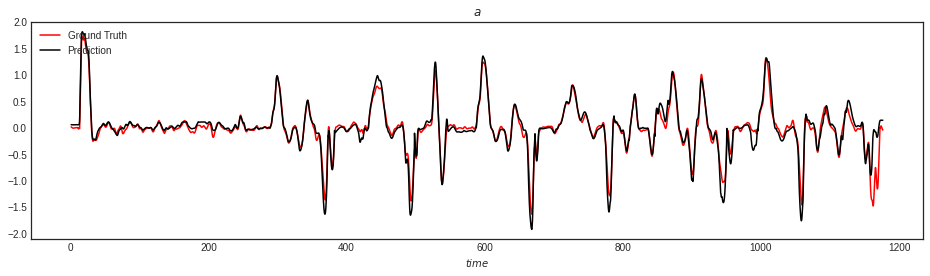

In [161]:
# Plotting 
true_acc = df_out['FOLLOW_ACC'].to_numpy()
pred_acc = df_out['Model forecast'].to_numpy()

fig, ax = plt.subplots(1) 

fig.set_figheight(4)
fig.set_figwidth(16)

g1, = ax.plot(t[:], true_acc, 'r')   # use v_p as well 
p1, = ax.plot(t[:], pred_acc, 'k')
ax.set_title('$a$')
ax.legend((g1, p1), ('Ground Truth', 'Prediction'), loc='upper left', shadow=False)
plt.xlabel("$time$")
#plt.savefig('ResearchUpdate#40/veryGoodModel1.png')
plt.show()

In [162]:
# save the model 
#with open('ResearchUpdate#43/LSTModels/JIANG/LSTM_Stand_JIANG(A).pkl','wb') as f:
#    pickle.dump(model,f)

Loading the model

In [32]:
# loading the model
with open('../LSTMModels/JIANG/LSTM_Stand_JIANG(A).pkl', 'rb') as f:
    model = pickle.load(f)

# RMSE(A)

In [33]:
train_size = np.array(df_lstm_train).shape[0]
test_size = np.array(df_lstm_test).shape[0]

lstm_train_a = torch.zeros(train_size)   # contains unnormalized predictions 
lstm_train_v = torch.zeros(train_size)
lstm_train_pos = torch.zeros(train_size)
lstm_train_s = torch.zeros(train_size)

lstm_test_a = torch.zeros(test_size)
lstm_test_v = torch.zeros(test_size)
lstm_test_pos = torch.zeros(test_size)
lstm_test_s = torch.zeros(test_size)

lstm_train_v[0] = v[0]
lstm_train_pos[0] = followPos[0]
lstm_train_s[0] = s[0]

#lstm_test_v[0] = v[train_size]
#lstm_test_pos[0] = followPos[train_size]
#lstm_test_s[0] = s[train_size]

def predict(data_loader, model):
    output = torch.tensor([])
    model.eval()
    k = 0
    if data_loader == test_loader:
        lstm_test_v[0] = lstm_train_v[train_size-1]
        lstm_test_pos[0] = lstm_train_pos[train_size-1]
        lstm_test_s[0] = lstm_train_s[train_size-1]
    with torch.no_grad():
        for X, _ in data_loader:
            if data_loader == train_eval_loader:
                y_star = model(X)                                                  # Normalize ACC 
                lstm_train_a[k] = y_star*target_stdev + target_mean                # Unnormalize ACC
                if k != train_size-1:
                    lstm_train_v[k+1] = lstm_train_v[k]+(lstm_train_a[k])*(0.1)        # Unnormalize VEL 
                    norm_v = (lstm_train_v[k+1]-vel_mean) / vel_stdev                  # Normalize VEL
                    df_lstm_train.loc[k+1, 'FOLLOW_VEL'] = norm_v.item()               # Updating Dataframe   
                    lstm_train_pos[k+1] = lstm_train_pos[k] + (lstm_train_v[k+1]+lstm_train_v[k])*(dt) / 2 #+ (0.5)*(lstm_train_a[k])*(dt**2) # Unnormalize POS
                    lstm_train_s[k+1] = leadPos[k+1] - lstm_train_pos[k+1] - leadLen[0]           # Calculating HEADWAY
                    h_star_norm = (lstm_train_s[k+1]-headway_mean) / headway_stdev                  # Normalize HEADWAY
                    df_lstm_train.loc[k+1, 'HEADWAY'] = h_star_norm.item()             # Updating Dataframe 
            elif data_loader == test_loader:
                y_star = model(X)                                                  # Normalize ACC 
                lstm_test_a[k] = y_star*target_stdev + target_mean                 # Unnormalize ACC
                if k != test_size-1:
                    lstm_test_v[k+1] = lstm_test_v[k]+(lstm_test_a[k])*(0.1)           # Unnormalize VEL 
                    norm_v = (lstm_test_v[k+1]-vel_mean) / vel_stdev                  # Normalize VEL 
                    df_lstm_test.loc[k+1, 'FOLLOW_VEL'] = norm_v.item()                # Updating Dataframe  
                    lstm_test_pos[k+1] = lstm_test_pos[k] + (lstm_train_v[k+1]+lstm_test_v[k])*(dt) / 2 #+ (0.5)*(lstm_test_a[k])*(dt**2) # Unnormalize POS
                    lstm_test_s[k+1] = leadPos[k+train_size+1] - lstm_test_pos[k+1] - leadLen[0]            # Calculating HEADWAY
                    h_star_norm = (lstm_test_s[k+1]-headway_mean)/headway_stdev                  # Normalize HEADWAY
                    df_lstm_test.loc[k+1, 'HEADWAY'] = h_star_norm.item()              # Updating Dataframe    
            k += 1     
    return output

In [34]:
train_eval_dataset = SequenceDataset(
    df_lstm_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)
train_eval_loader = DataLoader(train_eval_dataset, batch_size=1, shuffle=False) # shuffle=False

ystar_col = "Model_Forecast"
predict(train_eval_loader, model).numpy()
predict(test_loader, model).numpy()

array([], dtype=float32)

In [35]:
lstm_train_a_np = lstm_train_a.detach().cpu().numpy()
lstm_train_v_np = lstm_train_v.detach().cpu().numpy()
lstm_train_pos_np = lstm_train_pos.detach().cpu().numpy()
lstm_train_s_np = lstm_train_s.detach().cpu().numpy()

lstm_test_a_np = lstm_test_a.detach().cpu().numpy()
lstm_test_v_np = lstm_test_v.detach().cpu().numpy()
lstm_test_pos_np = lstm_test_pos.detach().cpu().numpy()
lstm_test_s_np = lstm_test_s.detach().cpu().numpy()

lstm_pred_a = np.concatenate((lstm_train_a_np, lstm_test_a_np))
lstm_pred_v = np.concatenate((lstm_train_v_np, lstm_test_v_np))
lstm_pred_pos = np.concatenate((lstm_train_pos_np, lstm_test_pos_np))
lstm_pred_s = np.concatenate((lstm_train_s_np, lstm_test_s_np))


In [37]:
# saving data in csv files 
allData = np.stack((lstm_pred_a, lstm_pred_v, lstm_pred_s, v_p, v, s), axis=1)
#np.savetxt('../../../Results/LSTM/Predictions/JIANG/LSTM_Stand_JIANG(A).csv', allData, delimiter=',')

In [17]:
# loading predictions from csv files
my_data = genfromtxt('../../../Results/LSTM/Predictions/JIANG/LSTM_Stand_JIANG(A).csv', delimiter=',')
lstm_pred_a = my_data[:,0]
lstm_pred_v = my_data[:,1]
lstm_pred_s = my_data[:,2]
v_p = my_data[:,3]
v = my_data[:,4]
s = my_data[:,5]

Train Acc. RMSE: 0.3933849577451358
Train Vel. RMSE 4.403830935807702
Train Head. RMSE 295.1588654342521
Test Acc. RMSE: 0.3084608758149166
Test Vel. RMSE 5.510722674228758
Test Head. RMSE 773.7684355609078


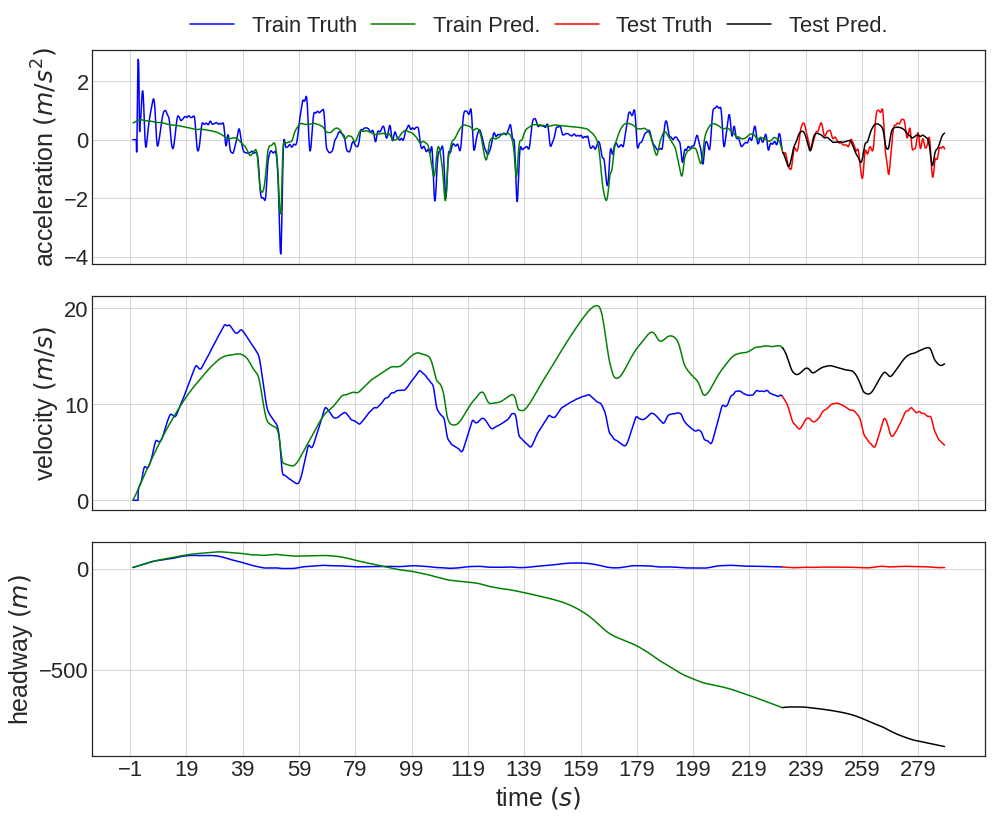

In [24]:
# Plotting 
en_Traj = 2307
acc_truth_plot = np.stack((v_p[en_Traj:],t[en_Traj:]), axis=1)
v_truth_plot = np.stack((v[en_Traj:],t[en_Traj:]), axis=1)
s_truth_plot = np.stack((s[en_Traj:],t[en_Traj:]), axis=1)

#lstm_pred = np.array(df_out['Model_Forecast'])

print('Train Acc. RMSE:', np.sqrt(mean_squared_error(lstm_pred_a[:en_Traj+1], v_p[:en_Traj+1])))
print("Train Vel. RMSE", np.sqrt(mean_squared_error(lstm_pred_v[:en_Traj+1], v[:en_Traj+1])))
print("Train Head. RMSE", np.sqrt(mean_squared_error(lstm_pred_s[:en_Traj+1], s[:en_Traj+1])))

print('Test Acc. RMSE:', np.sqrt(mean_squared_error(lstm_pred_a[en_Traj+1:], v_p[en_Traj+1:])))
print("Test Vel. RMSE", np.sqrt(mean_squared_error(lstm_pred_v[en_Traj+1:], v[en_Traj+1:])))
print("Test Head. RMSE", np.sqrt(mean_squared_error(lstm_pred_s[en_Traj+1:], s[en_Traj+1:])))

fig = plt.figure() 

gs = fig.add_gridspec(3, hspace=0.15)
ax = gs.subplots(sharex=True)

fig.set_figheight(13)
fig.set_figwidth(16)

plt.rc('font', size=22)          # controls default text sizes
plt.rc('axes', titlesize=22)     # fontsize of the axes title
plt.rc('axes', labelsize=25)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=22)    # fontsize of the tick labels
plt.rc('ytick', labelsize=22)    # fontsize of the tick labels
plt.rc('legend', fontsize=22)    # legend fontsize
plt.rc('figure', titlesize=12)  # fontsize of the figure title

b1, = ax[0].plot(X_train[:,3], Y_train[:,0], "b")
g1, = ax[0].plot(X_prior[:en_Traj+1,3], lstm_pred_a[:en_Traj+1], "g")
r1, = ax[0].plot(acc_truth_plot[:,1], acc_truth_plot[:,0], "r")
k1, = ax[0].plot(X_prior[en_Traj+1:,3], lstm_pred_a[en_Traj+1:], "k")
ax[0].set_ylabel('acceleration $(m/s^2)$')
ax[0].grid(True)
ax[0].xaxis.set_ticks(np.arange(min(t), max(t), 20)-1)

ax[1].plot(X_train[:,3], X_train[:,0], "b")
ax[1].plot(X_prior[:en_Traj+1,3], lstm_pred_v[:en_Traj+1], "g")
ax[1].plot(v_truth_plot[:,1], v_truth_plot[:,0], "r")
ax[1].plot(X_prior[en_Traj+1:,3], lstm_pred_v[en_Traj+1:], "k")
ax[1].set_ylabel('velocity $(m/s)$')
ax[1].grid(True)

ax[2].plot(X_train[:,3], X_train[:,1], "b")
ax[2].plot(X_prior[:en_Traj+1,3], lstm_pred_s[:en_Traj+1], "g")
ax[2].plot(s_truth_plot[:,1], s_truth_plot[:,0], "r")
ax[2].plot(X_prior[en_Traj+1:,3], lstm_pred_s[en_Traj+1:], "k")
ax[2].set_ylabel('headway $(m)$')
ax[2].grid(True)
ax[2].set_xlabel('time $(s)$')

ax[0].legend((b1, g1, r1, k1), ('Train Truth', 'Train Pred.', 'Test Truth', 'Test Pred.'), bbox_to_anchor=(0.1,1.02,0.8,0.2), mode='expand', loc='lower left', ncol=4, borderaxespad=0, shadow=False)

plt.savefig('../../../Results/LSTM/Plots/JIANG/LSTM_Stand_JIANG(A).png')
plt.show()